In [1]:
import requests
import folium

def plot_osrm_route(locations, map_filename='route_map.html'):
    """
    locations: list of [lat, lon]
    map_filename: output HTML file
    """
    # Convert to lon,lat order for OSRM
    coords_str = ";".join([f"{lon},{lat}" for lat, lon in locations])

    # Request route from OSRM public server
    url = f"http://router.project-osrm.org/route/v1/driving/{coords_str}"
    params = {
        "overview": "full",     # get full geometry
        "geometries": "geojson" # geojson geometry
    }

    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()

    route_coords = data['routes'][0]['geometry']['coordinates']  # list of [lon,lat]
    distance_km = data['routes'][0]['distance'] / 1000
    duration_min = data['routes'][0]['duration'] / 60

    print(f"Route distance: {distance_km:.2f} km")
    print(f"Route duration: {duration_min:.1f} min")

    # Create folium map centered on first location
    start_lat, start_lon = locations[0]
    fmap = folium.Map(location=[start_lat, start_lon], zoom_start=13)

    # Add route line
    route_latlon = [[lat, lon] for lon, lat in route_coords]  # convert to [lat,lon]
    folium.PolyLine(route_latlon, color='blue', weight=5, opacity=0.8).add_to(fmap)

    # Add markers
    folium.Marker([start_lat, start_lon], popup="Start", icon=folium.Icon(color='green')).add_to(fmap)
    end_lat, end_lon = locations[-1]
    folium.Marker([end_lat, end_lon], popup="End", icon=folium.Icon(color='red')).add_to(fmap)

    # Optional: intermediate points
    for lat, lon in locations[1:-1]:
        folium.CircleMarker([lat, lon], radius=4, color='gray', fill=True).add_to(fmap)

    # Save to HTML
    fmap.save(map_filename)
    print(f"Map saved to {map_filename}")
    return fmap


# Example usage:
locations = [
    [1.290270, 103.851959],  # Marina Bay, Singapore
    [1.352083, 103.819839],  # Another point
    [1.282302, 103.819836]   # Another point
]

plot_osrm_route(locations)


Route distance: 25.13 km
Route duration: 39.6 min
Map saved to route_map.html


In [3]:
import requests
import pandas as pd

def osrm_distance_matrix(locations):
    """
    locations: list of [lat, lon]
    returns: pandas DataFrame of pairwise distances in km
    """
    # Convert to lon,lat for OSRM
    coords_str = ";".join([f"{lon},{lat}" for lat, lon in locations])

    # Request distance matrix from OSRM table service
    url = f"http://router.project-osrm.org/table/v1/driving/{coords_str}"
    params = {
        "annotations": "distance"  # return distances
    }

    resp = requests.get(url, params=params)
    resp.raise_for_status()
    data = resp.json()

    # distances in meters
    distances_m = data['distances']  # square matrix
    distances_km = [[round(m/1000, 2) for m in row] for row in distances_m]

    # Create DataFrame
    labels = [f"P{i+1}" for i in range(len(locations))]
    df = pd.DataFrame(distances_m, columns=labels, index=labels)

    return df

# Example usage
locations = [
    [1.290270, 103.851959],  # Marina Bay
    [1.352083, 103.819839],  # Somewhere north
    [1.282302, 103.819836]   # Somewhere west
]

df = osrm_distance_matrix(locations)
print(df)

df.to_csv("distance_matrix.csv")
print("Saved distance matrix to distance_matrix.csv")


         P1       P2       P3
P1      0.0  10780.5   5240.5
P2  11491.8      0.0  14331.8
P3   6033.8  15694.4      0.0
Saved distance matrix to distance_matrix.csv


# Try creating a pairwise distance matrix from OSRM with my dummy locations

In [4]:
# My locations
my_locations = pd.read_csv("data/locations_w_node_id.csv")
my_locations.head()

,id,location_name,location_type,lat,lon,node_id
0,school_1,Admiralty Primary School,school,1.44294,103.80035,8655379195
1,school_2,Jurong West Primary School,school,1.33931,103.69903,7437327501
2,school_3,River Valley Primary School,school,1.29430,103.83593,11938018645
3,school_4,Casuarina Primary School,school,1.37281,103.95723,8302208139
4,school_5,St. Joseph’s Institution Junior,school,1.31751,103.84632,10979316519


In [6]:
# Create list of lat lons
lat_list = list(my_locations['lat'])
lon_list = list(my_locations['lon'])

location_coordinates = [[lat, lon] for lat, lon in zip(lat_list, lon_list)]

In [10]:
osrm_pairwise_distance_matrix = osrm_distance_matrix(location_coordinates)
osrm_pairwise_distance_matrix

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
P1,0.0,21540.1,25038.5,25018.8,22000.5,24032.3,13657.3,17329.5,4100.0,20732.2,...,27389.9,12562.9,10195.8,21956.2,30747.7,23200.9,17687.4,14476.5,20471.7,25827.6
P2,21214.5,0.0,20892.3,37369.7,20995.4,26298.9,21792.1,26889.6,18670.3,11282.2,...,20857.8,22339.9,26497.1,10684.3,18868.5,16614.9,16020.3,9570.7,11021.7,6465.5
P3,25144.2,22520.0,0.0,22545.9,4706.0,7585.6,11353.2,13277.1,20804.6,10219.8,...,2085.9,11334.6,13289.2,12550.3,5723.4,4977.1,6066.3,17688.9,9815.7,19495.4
P4,25169.5,38443.5,22194.6,0.0,19156.6,14034.4,17044.1,12341.7,26507.7,31814.3,...,24546.0,15962.7,20831.8,33616.2,27903.8,27232.0,22934.0,32758.4,31553.8,40561.2
P5,21783.9,20860.4,4134.0,19185.6,0.0,5707.9,6548.6,9916.8,19074.8,14231.2,...,5223.8,7974.4,7580.9,16868.1,11155.7,10483.9,5350.9,15959.1,13970.7,23813.1
P6,22539.4,26280.0,8047.9,14617.2,5471.8,0.0,8465.5,7916.4,23877.6,19650.8,...,8134.8,8729.8,10684.5,17926.7,11246.3,11542.5,10770.4,21378.7,19390.2,24871.7
P7,13640.0,22719.9,11366.3,17565.5,6607.8,10360.1,0.0,6541.7,14978.2,16090.6,...,13717.7,2530.7,3908.7,16858.7,17075.5,12519.4,7005.8,17818.5,14478.0,23803.7
P8,17773.3,28111.0,13331.3,12891.6,10293.3,8281.6,6716.6,0.0,19111.5,21481.8,...,15682.7,5031.3,8163.6,24752.9,19040.5,18368.7,12397.0,23209.6,19869.1,31697.9
P9,4122.0,18462.2,20589.9,25452.3,19142.2,24445.7,14090.8,17763.0,0.0,17654.3,...,21466.0,12996.4,10629.4,18878.3,26288.8,21929.9,17334.3,11398.5,17393.8,22749.7
P10,19999.1,11655.7,11943.2,31379.9,12887.9,20309.1,15802.3,20899.8,17454.9,0.0,...,11908.7,16350.1,16698.8,3111.8,9919.3,7665.7,8189.1,10650.7,1111.3,9244.4


In [ ]:
from src import helpers
# Compare it to OSMnx scraped pariwise distance matrix
fp = 'data/pairwise_dist_matrix.pkl'
pairwise_dist_matrix = helpers.read_pickle(fp)
pairwise_dist_matrix_df = pd.DataFrame(pairwise_dist_matrix)
pairwise_dist_matrix_df


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0,20995.0,25439.0,25463.0,17623.0,22841.0,13945.0,16524.0,3667.0,19713.0,...,22924.0,12774.0,10472.0,20062.0,26858.0,23457.0,18116.0,13367.0,19671.0,25263.0
1,20995.0,0.0,21213.0,38108.0,20880.0,26646.0,21613.0,27861.0,18737.0,9412.0,...,19685.0,23286.0,23312.0,10212.0,19062.0,16770.0,15326.0,9151.0,9370.0,6320.0
2,25439.0,21213.0,0.0,21948.0,3850.0,7309.0,8709.0,13177.0,20996.0,11701.0,...,811.0,11270.0,12992.0,11710.0,5119.0,4217.0,5578.0,17684.0,11351.0,18983.0
3,25463.0,38108.0,21948.0,0.0,18434.0,12917.0,17297.0,12932.0,25066.0,30591.0,...,22095.0,16909.0,20765.0,30940.0,25110.0,26365.0,21541.0,33535.0,28617.0,37735.0
4,17623.0,20880.0,3850.0,18434.0,0.0,5093.0,5597.0,9829.0,18894.0,12084.0,...,4251.0,7922.0,7345.0,12141.0,9199.0,9114.0,4230.0,15582.0,11305.0,23018.0
5,22841.0,26646.0,7309.0,12917.0,5093.0,0.0,7890.0,7812.0,22653.0,17560.0,...,7907.0,8618.0,10340.0,17569.0,10493.0,10938.0,9524.0,19877.0,17209.0,24842.0
6,13945.0,21613.0,8709.0,17297.0,5597.0,7890.0,0.0,6662.0,14022.0,13625.0,...,8841.0,2620.0,3762.0,13928.0,12852.0,11469.0,6128.0,15963.0,13092.0,20505.0
7,16524.0,27861.0,13177.0,12932.0,9829.0,7812.0,6662.0,0.0,17217.0,19688.0,...,13443.0,4585.0,7115.0,19992.0,17799.0,17714.0,12191.0,22027.0,19155.0,31618.0
8,3667.0,18737.0,20996.0,25066.0,18894.0,22653.0,14022.0,17217.0,0.0,17337.0,...,20548.0,13141.0,10840.0,17686.0,24482.0,21081.0,15740.0,10991.0,17294.0,22887.0
9,19713.0,9412.0,11701.0,30591.0,12084.0,17560.0,13625.0,19688.0,17337.0,0.0,...,9240.0,15258.0,15284.0,877.0,9468.0,7176.0,7766.0,9806.0,607.0,7469.0


In [22]:
old_col_names = [i for i in pairwise_dist_matrix_df.columns.copy()]
old_col_names

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]

In [24]:
# Rename osmnx df
osrm_col_names = [f'P{i+1}' for i in pairwise_dist_matrix_df.index]
pairwise_dist_matrix_df.columns = osrm_col_names
pairwise_dist_matrix_df.index = osrm_col_names

In [37]:
pairwise_dist_matrix_df

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
P1,0.0,20995.0,25439.0,25463.0,17623.0,22841.0,13945.0,16524.0,3667.0,19713.0,...,22924.0,12774.0,10472.0,20062.0,26858.0,23457.0,18116.0,13367.0,19671.0,25263.0
P2,20995.0,0.0,21213.0,38108.0,20880.0,26646.0,21613.0,27861.0,18737.0,9412.0,...,19685.0,23286.0,23312.0,10212.0,19062.0,16770.0,15326.0,9151.0,9370.0,6320.0
P3,25439.0,21213.0,0.0,21948.0,3850.0,7309.0,8709.0,13177.0,20996.0,11701.0,...,811.0,11270.0,12992.0,11710.0,5119.0,4217.0,5578.0,17684.0,11351.0,18983.0
P4,25463.0,38108.0,21948.0,0.0,18434.0,12917.0,17297.0,12932.0,25066.0,30591.0,...,22095.0,16909.0,20765.0,30940.0,25110.0,26365.0,21541.0,33535.0,28617.0,37735.0
P5,17623.0,20880.0,3850.0,18434.0,0.0,5093.0,5597.0,9829.0,18894.0,12084.0,...,4251.0,7922.0,7345.0,12141.0,9199.0,9114.0,4230.0,15582.0,11305.0,23018.0
P6,22841.0,26646.0,7309.0,12917.0,5093.0,0.0,7890.0,7812.0,22653.0,17560.0,...,7907.0,8618.0,10340.0,17569.0,10493.0,10938.0,9524.0,19877.0,17209.0,24842.0
P7,13945.0,21613.0,8709.0,17297.0,5597.0,7890.0,0.0,6662.0,14022.0,13625.0,...,8841.0,2620.0,3762.0,13928.0,12852.0,11469.0,6128.0,15963.0,13092.0,20505.0
P8,16524.0,27861.0,13177.0,12932.0,9829.0,7812.0,6662.0,0.0,17217.0,19688.0,...,13443.0,4585.0,7115.0,19992.0,17799.0,17714.0,12191.0,22027.0,19155.0,31618.0
P9,3667.0,18737.0,20996.0,25066.0,18894.0,22653.0,14022.0,17217.0,0.0,17337.0,...,20548.0,13141.0,10840.0,17686.0,24482.0,21081.0,15740.0,10991.0,17294.0,22887.0
P10,19713.0,9412.0,11701.0,30591.0,12084.0,17560.0,13625.0,19688.0,17337.0,0.0,...,9240.0,15258.0,15284.0,877.0,9468.0,7176.0,7766.0,9806.0,607.0,7469.0


In [27]:
diff_df = osrm_pairwise_distance_matrix - pairwise_dist_matrix_df
diff_df

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31
P1,0.0,545.1,-400.5,-444.2,4377.5,1191.3,-287.7,805.5,433.0,1019.2,...,4465.9,-211.1,-276.2,1894.2,3889.7,-256.1,-428.6,1109.5,800.7,564.6
P2,219.5,0.0,-320.7,-738.3,115.4,-347.1,179.1,-971.4,-66.7,1870.2,...,1172.8,-946.1,3185.1,472.3,-193.5,-155.1,694.3,419.7,1651.7,145.5
P3,-294.8,1307.0,0.0,597.9,856.0,276.6,2644.2,100.1,-191.4,-1481.2,...,1274.9,64.6,297.2,840.3,604.4,760.1,488.3,4.9,-1535.3,512.4
P4,-293.5,335.5,246.6,0.0,722.6,1117.4,-252.9,-590.3,1441.7,1223.3,...,2451.0,-946.3,66.8,2676.2,2793.8,867.0,1393.0,-776.6,2936.8,2826.2
P5,4160.9,-19.6,284.0,751.6,0.0,614.9,951.6,87.8,180.8,2147.2,...,972.8,52.4,235.9,4727.1,1956.7,1369.9,1120.9,377.1,2665.7,795.1
P6,-301.6,-366.0,738.9,1700.2,378.8,0.0,575.5,104.4,1224.6,2090.8,...,227.8,111.8,344.5,357.7,753.3,604.5,1246.4,1501.7,2181.2,29.7
P7,-305.0,1106.9,2657.3,268.5,1010.8,2470.1,0.0,-120.3,956.2,2465.6,...,4876.7,-89.3,146.7,2930.7,4223.5,1050.4,877.8,1855.5,1386.0,3298.7
P8,1249.3,250.0,154.3,-40.4,464.3,469.6,54.6,0.0,1894.5,1793.8,...,2239.7,446.3,1048.6,4760.9,1241.5,654.7,206.0,1182.6,714.1,79.9
P9,455.0,-274.8,-406.1,386.3,248.2,1792.7,68.8,546.0,0.0,317.3,...,918.0,-144.6,-210.6,1192.3,1806.8,848.9,1594.3,407.5,99.8,-137.3
P10,286.1,2243.7,242.2,788.9,803.9,2749.1,2177.3,1211.8,117.9,0.0,...,2668.7,1092.1,1414.8,2234.8,451.3,489.7,423.1,844.7,504.3,1775.4


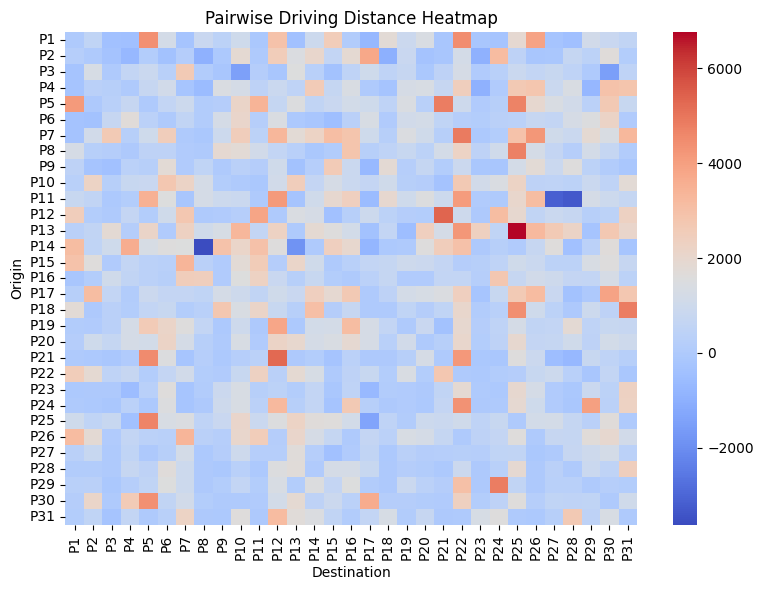

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    diff_df,
    # annot=True,
    fmt=".1f",
    cmap="coolwarm",  # cool colors for low, warm for high
    # cbar_kws={"label": "Distance (km)"}
)
plt.title("Pairwise Driving Distance Heatmap")
plt.xlabel("Destination")
plt.ylabel("Origin")
plt.tight_layout()
plt.show()

In [ ]:
# next steps, translate geocoded coordiates into 